In [42]:
from fastai.vision.all import *
from fastai.torch_core import TensorMask, TensorImage

import rasterio as rio

import timm
import torch
import fastai
from rasterio.enums import Resampling
import torch.multiprocessing
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [43]:
# download training data here
# https://drive.google.com/drive/folders/1Z60g3SxBiSTEZzuHDPOUuNL7I_Mg_dGq?usp=share_link

In [44]:
print(torch.__version__)
print(fastai.__version__)
print(default_device())

2.0.0.post200
2.7.12
cuda:0


In [45]:
model_details = {"model_type": "regnety_006", "fp_16": True, "lr": 1e-3}

In [46]:
device = default_device()
device

device(type='cuda', index=0)

In [47]:
model_version = "1.17"  # Assigns string value to model_version
model_name = f"{model_details['model_type']}_v{model_version}_model"  # Assigns string value to model_name
temp_file_name = model_name + "_temp"
model_name, temp_file_name

('regnety_006_v1.17_model', 'regnety_006_v1.17_model_temp')

In [48]:
time_steps = 6
bands_per_timestep = 2

In [49]:
limited_band_read_list = [
    # 1,
    2,
    # 3,
    4,
    #  5,
    6,
    # 7,
    8,
    #  9,
    10,
    # 11,
    12,
    #  13,
    14,
    # 15,
    16,
    #  17,
    18,
    # 19,
    20,
    #  21,
    22,
    # 23,
    24,
]

In [50]:
bands_per_timestep = int(len(limited_band_read_list) / time_steps)
bands_per_timestep

2

In [51]:
path = Path("/media/nick/SNEAKERNET/training data")
label_path = path / "labels_2_3_4_8_V3"
images_path = path / "images_2_3_4_8_V3"
print(label_path.exists(), images_path.exists())

True True


In [52]:
def label_func(label_path, file_path):
    label_path = label_path / file_path.name

    return label_path

In [53]:
# func to get img list to use excluding the bad images
def get_image_files_custom(source, p=False):
    return list(source.glob("[!.]*.tif"))

In [54]:
f_names = list(get_image_files_custom(images_path))
len(f_names)

1711

In [55]:
f_names[0]

Path('/media/nick/SNEAKERNET/training data/images_2_3_4_8_V3/388_OSM_80.tif')

In [56]:
validation_paths = []
for type in ["OSM", "NZ", "Aus"]:
    for i in range(15):
        file = images_path / f"{i}_{type}_80.tif"
        if file.exists():
            validation_paths.append(file)
            # print(file.exists())
    # validation_paths.append()
len(validation_paths)

44

In [57]:
def is_valid_file(x, validation_paths):
    return x in validation_paths

In [58]:
torch.zeros(12, 128, 128).shape

torch.Size([12, 128, 128])

In [59]:
class Switcheroo(RandTransform):
    "Randomly switch the order of the time steps, keeping the band order the same"

    split_idx, order = 0, 2

    def __init__(self, p=1, bands_per_timestep=2, time_steps=3):
        super().__init__(p=p)
        self.bands_per_timestep = bands_per_timestep
        self.time_steps = time_steps

    def encodes(self, x: (TensorImage)):
        new_time_step_order = torch.randperm(self.time_steps)
        new_order = [
            (i * self.bands_per_timestep) + j
            for i in new_time_step_order
            for j in range(self.bands_per_timestep)
        ]
        return x[:, new_order]

In [60]:
class BatchRot90(RandTransform):
    "Rotate image and mask by 0, 90, 180, or 270 degrees"
    split_idx, order = 0, 2

    def __init__(self, p=1):
        super().__init__(p=p)
        self.rots = 0

    def before_call(self, b, split_idx):
        if random.random() < self.p:
            self.rot = random.choice([0, 1, 2, 3])
        else:
            self.rot = 0

    def encodes(self, x: (TensorImage, TensorMask)):
        return x.rot90(self.rot, [-2, -1])

In [61]:
def open_mask(img_path, img_size):
    with rio.open(img_path) as src:
        raw_bands = src.read(
            1, out_shape=(img_size, img_size), resampling=Resampling.nearest
        )
    return TensorMask(torch.from_numpy(raw_bands))

In [62]:
device

device(type='cuda', index=0)

In [63]:
def open_sar(img_path, img_size):
    sar_img_path = sar_path / img_path.name
    raw_bands = torch.zeros(1, img_size, img_size)
    if sar_img_path.exists():
        with rio.open(sar_img_path) as src:
            raw_bands = src.read(
                out_shape=(img_size, img_size),
                resampling=Resampling.nearest,
            )
    return raw_bands

In [64]:
image_cache = {}

In [65]:
def open_img(img_path, img_size):
    if img_path in image_cache:
        return image_cache[img_path]
    with rio.open(img_path) as src:
        raw_bands = src.read(limited_band_read_list, out_shape=(img_size, img_size))

    tensor_img = (
        TensorImage(torch.from_numpy(raw_bands.astype("float16"))).half().cuda()
    )
    image_cache[img_path] = tensor_img
    return tensor_img

In [66]:
open_img(f_names[0], 128).shape

torch.Size([12, 128, 128])

In [67]:
bands_per_timestep

2

In [68]:
all_means = []
all_stds = []
for i in tqdm(f_names):
    image_tensor = open_img(i, 128) / 32767
    all_means.append(image_tensor.mean((1, 2)).tolist())
    all_stds.append(image_tensor.std((1, 2)).tolist())
all_stds = np.array(all_stds).mean((0))
all_means = np.array(all_means).mean((0))
# break

  0%|          | 0/1711 [00:00<?, ?it/s]

In [69]:
all_means

array([0.09561849, 0.09644007, 0.09435602, 0.09631168, 0.09356618,
       0.09504625, 0.09509373, 0.09508776, 0.0911776 , 0.091464  ,
       0.09334985, 0.09400712])

In [70]:
all_stds

array([0.02369863, 0.03057647, 0.0244495 , 0.03169953, 0.02380443,
       0.03068336, 0.02376207, 0.03026029, 0.02387124, 0.03011121,
       0.02285621, 0.02902071])

In [71]:
# build datablock
def build_dblock(img_size):
    open_img_partial = partial(open_img, img_size=img_size)
    open_mask_partial = partial(open_mask, img_size=img_size)
    lable_func_partial = partial(label_func, label_path)

    dblock = DataBlock(
        blocks=(
            TransformBlock(open_img_partial),
            TransformBlock(open_mask_partial),
            # MaskBlock(),
        ),
        get_items=get_image_files_custom,
        get_y=lable_func_partial,
        splitter=FuncSplitter(lambda x: is_valid_file(x, validation_paths)),
        batch_tfms=[
            IntToFloatTensor(32767, 1),
            *aug_transforms(
                flip_vert=True,
                max_rotate=0,
                max_zoom=0.2,
                max_lighting=0.2,
                max_warp=0,
                p_affine=0,
                p_lighting=0.2,
                size=img_size,
            ),
            BatchRot90(),
            Switcheroo(bands_per_timestep=bands_per_timestep, time_steps=time_steps),
            Normalize.from_stats(mean=all_means, std=all_stds),
        ],
    )
    return dblock

In [72]:
dl = build_dblock(256).dataloaders(images_path, bs=16, num_workers=0)

In [73]:
ob = dl.one_batch()

KeyboardInterrupt: 

In [ ]:
ob[0].shape

torch.Size([16, 12, 256, 256])

In [ ]:
timm_model = partial(
    timm.create_model,
    model_details["model_type"],
    pretrained=True,
    in_chans=dl.one_batch()[0].shape[1],
)

In [ ]:
learner = unet_learner(
    dl, timm_model, pretrained=True, loss_func=MSELossFlat(), n_out=1
).to_fp16()

In [ ]:
cbs = [
    SaveModelCallback(monitor="valid_loss", fname=model_name, with_opt=True),
    ShowGraphCallback(),
]

epoch,train_loss,valid_loss,time
0,21.708437,10.679631,00:29
1,11.809448,4.610050,00:28
2,9.001637,4.528697,00:27
3,8.111399,4.111582,00:27
4,7.139234,3.514856,00:28
5,6.861903,3.698110,00:28
6,6.555537,3.980037,00:28
7,5.842789,4.426838,00:28
8,5.343504,2.667238,00:28
9,4.826183,2.934824,00:27


Better model found at epoch 0 with valid_loss value: 10.679631233215332.


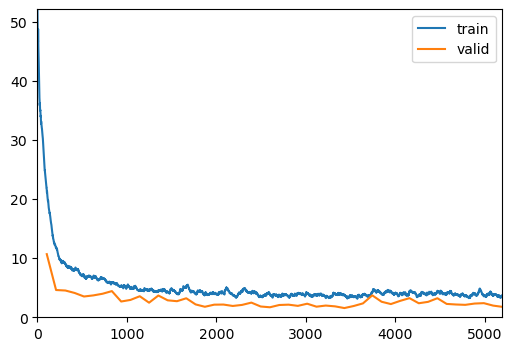

Better model found at epoch 1 with valid_loss value: 4.610049724578857.
Better model found at epoch 2 with valid_loss value: 4.528697490692139.
Better model found at epoch 3 with valid_loss value: 4.111581802368164.
Better model found at epoch 4 with valid_loss value: 3.5148558616638184.
Better model found at epoch 8 with valid_loss value: 2.667238473892212.
Better model found at epoch 11 with valid_loss value: 2.4678988456726074.
Better model found at epoch 16 with valid_loss value: 2.177386999130249.
Better model found at epoch 17 with valid_loss value: 1.7767207622528076.
Better model found at epoch 24 with valid_loss value: 1.6928534507751465.
Better model found at epoch 32 with valid_loss value: 1.5584560632705688.


epoch,train_loss,valid_loss,time
0,2.587943,1.448734,00:30
1,2.748591,1.381222,00:30
2,2.475755,1.378583,00:30
3,2.113076,1.330966,00:31
4,2.026715,1.198248,00:31
5,2.016613,1.082748,00:31
6,2.484637,1.213516,00:30
7,2.095538,1.105390,00:30
8,2.194331,1.255256,00:30
9,2.163575,1.088523,00:30


Better model found at epoch 0 with valid_loss value: 1.4487344026565552.


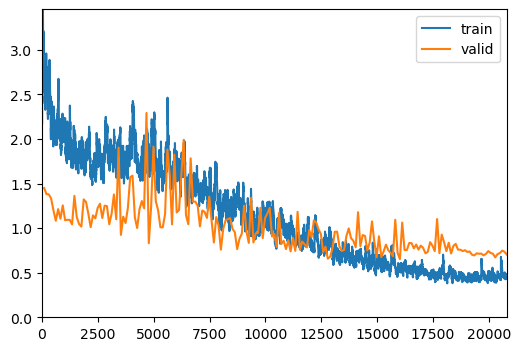

Better model found at epoch 1 with valid_loss value: 1.3812216520309448.
Better model found at epoch 2 with valid_loss value: 1.3785828351974487.
Better model found at epoch 3 with valid_loss value: 1.3309658765792847.
Better model found at epoch 4 with valid_loss value: 1.1982483863830566.
Better model found at epoch 5 with valid_loss value: 1.0827484130859375.
Better model found at epoch 12 with valid_loss value: 1.04241943359375.
Better model found at epoch 16 with valid_loss value: 1.017198920249939.
Better model found at epoch 20 with valid_loss value: 1.0107407569885254.
Better model found at epoch 33 with valid_loss value: 0.924236536026001.
Better model found at epoch 45 with valid_loss value: 0.8306264281272888.
Better model found at epoch 76 with valid_loss value: 0.7589272856712341.
Better model found at epoch 106 with valid_loss value: 0.738650381565094.
Better model found at epoch 120 with valid_loss value: 0.7327765822410583.
Better model found at epoch 122 with valid_los

In [ ]:
learner.fine_tune(
    freeze_epochs=50,
    epochs=200,
    cbs=cbs,
)

In [75]:
learner.load(model_name)

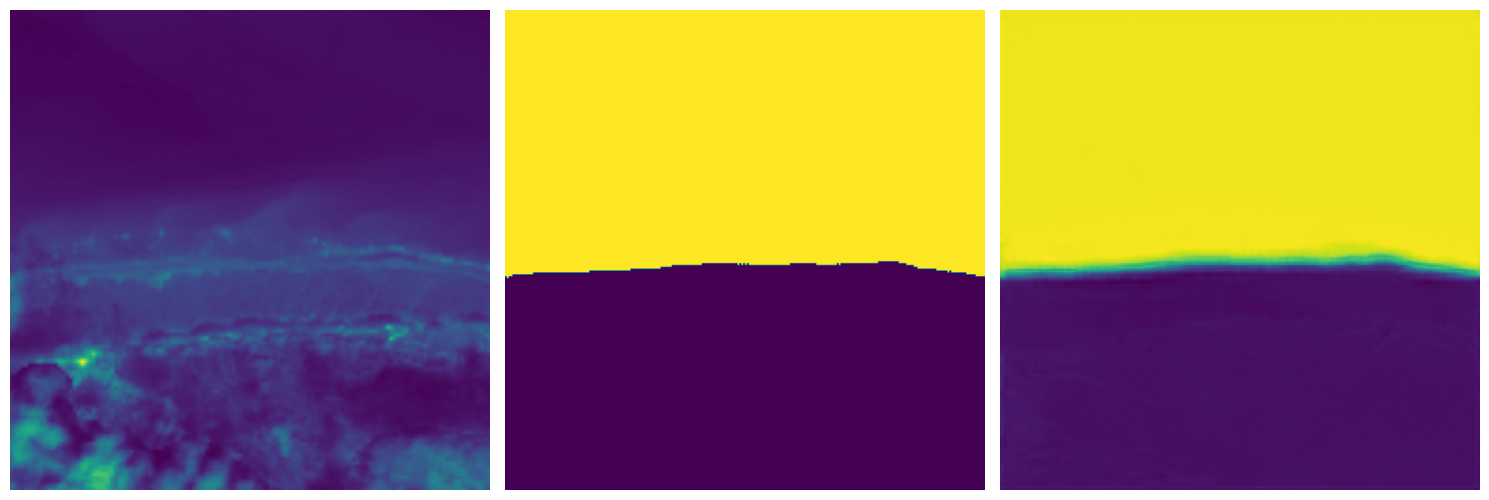

In [76]:
img_numb = 1
p = learner.predict(validation_paths[img_numb], with_input=True)

fig, axes = plt.subplots(1, 3, figsize=(15, 7))  # 1 row, 3 columns
axes[0].imshow(p[0].numpy()[2])
axes[0].axis("off")
axes[1].imshow(p[1].numpy()[0] > 0)
axes[1].axis("off")
axes[2].imshow(p[1].numpy()[0])
axes[2].axis("off")
plt.tight_layout()

In [77]:
pickle.dump(learner.model, open(f"{model_name}.pkl", "wb"))

In [78]:
f"{model_name}.pkl"

'regnety_006_v1.17_model.pkl'